In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
# import pandas library
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
import numpy as np
from sklearn.model_selection import train_test_split
#from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [7]:
df = pd.read_csv('/content/drive/MyDrive/Data/dk.csv')
print(df.head())
print('\n')
print(df.tail())
print('\n')
print(df.dtypes)
print(df.shape)

                       start                        end    load
0  2018-01-01 00:00:00+00:00  2018-01-01 01:00:00+00:00  3308.0
1  2018-01-01 01:00:00+00:00  2018-01-01 02:00:00+00:00  3118.0
2  2018-01-01 02:00:00+00:00  2018-01-01 03:00:00+00:00  3018.0
3  2018-01-01 03:00:00+00:00  2018-01-01 04:00:00+00:00  2916.0
4  2018-01-01 04:00:00+00:00  2018-01-01 05:00:00+00:00  2802.0


                           start                        end    load
22627  2020-07-31 19:00:00+00:00  2020-07-31 20:00:00+00:00  3353.0
22628  2020-07-31 20:00:00+00:00  2020-07-31 21:00:00+00:00  3242.0
22629  2020-07-31 21:00:00+00:00  2020-07-31 22:00:00+00:00  3015.0
22630  2020-07-31 22:00:00+00:00  2020-07-31 23:00:00+00:00  2813.0
22631  2020-07-31 23:00:00+00:00  2020-08-01 00:00:00+00:00  2695.0


start     object
end       object
load     float64
dtype: object
(22632, 3)


In [8]:
df.drop(columns = 'end', inplace = True)

In [9]:
df.rename(columns = {'start': 'date'}, inplace = True)
#convert data type to datetime
df.isetitem(df.columns.get_loc('date'), pd.to_datetime(df.loc[:,'date']))
print(df.dtypes)
print('\n')
# check for missing values
print(df.isna().sum())

date    datetime64[ns, UTC]
load                float64
dtype: object


date    0
load    0
dtype: int64


In [10]:
#check for invalid values
df.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())


date    True
load    True
dtype: bool

In [11]:
df.describe()

,load
count,22632.000000
mean,3834.388256
std,722.150368
min,1693.000000
25%,3258.000000
50%,3798.000000
75%,4389.000000
max,9618.000000


(array([1.100e+02, 5.735e+03, 7.774e+03, 6.853e+03, 2.152e+03, 3.000e+00,
        1.000e+00, 3.000e+00, 0.000e+00, 1.000e+00]),
 array([1693. , 2485.5, 3278. , 4070.5, 4863. , 5655.5, 6448. , 7240.5,
        8033. , 8825.5, 9618. ]),
 <BarContainer object of 10 artists>)

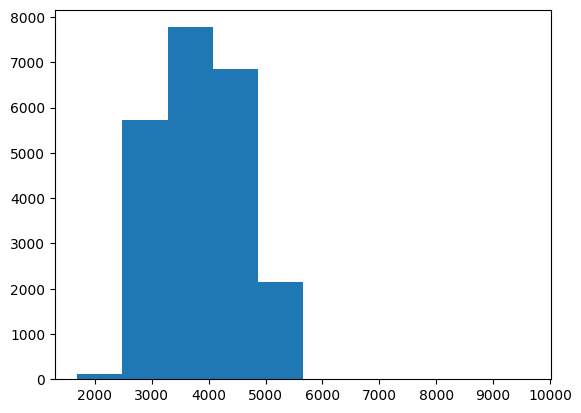

In [12]:
plt.hist(df['load'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f54190228c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f5419022e00>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f5419022620>],
 'medians': [<matplotlib.lines.Line2D at 0x7f5419023340>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f54190235e0>],
 'means': []}

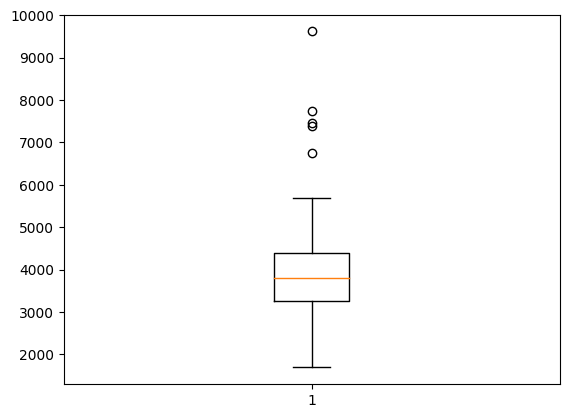

In [13]:
plt.boxplot(df['load'])

In [14]:
# stationarity test
df_stationarityTest = adfuller(df['load'], autolag='AIC')
print("P-value: ", df_stationarityTest[1])

P-value:  1.2076198486621206e-21


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


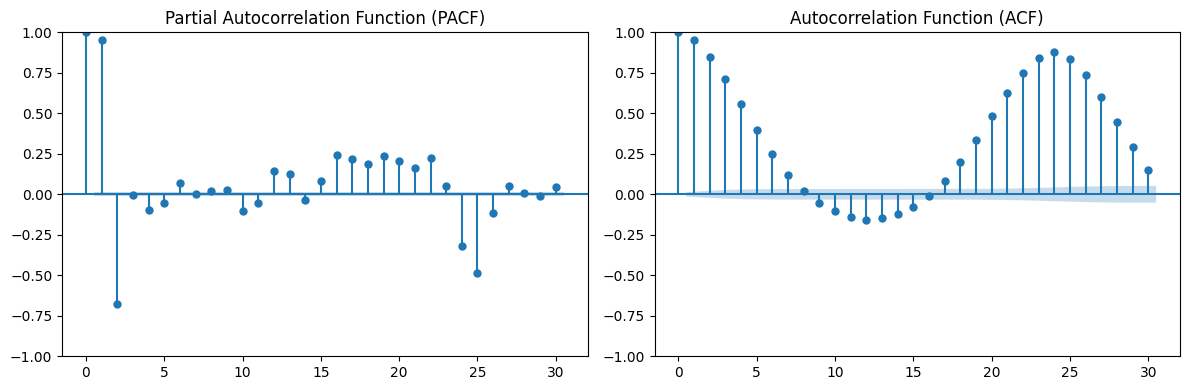

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
# Plot PACF 
plot_pacf(df['load'], lags=30, ax=ax1)
ax1.set_title('Partial Autocorrelation Function (PACF)')
# Plot ACF
plot_acf(df['load'], lags=30, ax=ax2)
ax2.set_title('Autocorrelation Function (ACF)')

plt.tight_layout()
plt.show()

In [98]:
df.iloc[train_start_index : train_end_index + 25]

,date,load
0,2018-01-01 00:00:00+00:00,3308.0
1,2018-01-01 01:00:00+00:00,3118.0
2,2018-01-01 02:00:00+00:00,3018.0
3,2018-01-01 03:00:00+00:00,2916.0
4,2018-01-01 04:00:00+00:00,2802.0
...,...,...
17539,2020-01-01 19:00:00+00:00,3810.0
17540,2020-01-01 20:00:00+00:00,3601.0
17541,2020-01-01 21:00:00+00:00,3375.0
17542,2020-01-01 22:00:00+00:00,3198.0


In [197]:
test_data['date'].dt.strftime("%A").iloc[0]

'Wednesday'

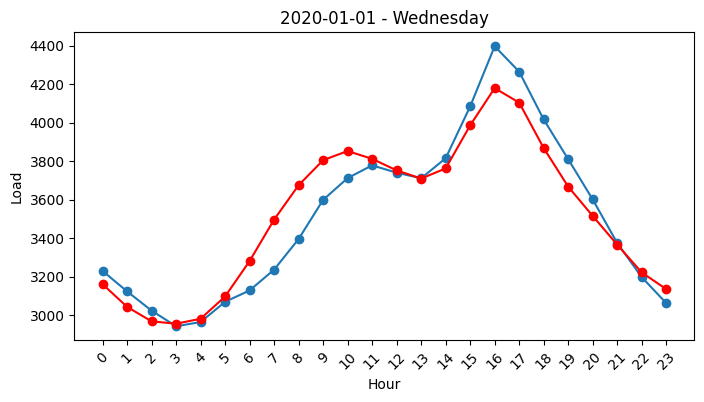

In [198]:
# upravit df, aby obsahoval i rok 2019
# vymyslet tak, ze se bude predikovat vzdy na den dopredu, testova hodnota prejde dalsi den do trenovaciho setu, pretrenuje se model a urci se predikce na dalsi den. Takhle to rolovat pro cely mesic, kdyz bude vypocet rychly, tak klidne cely rok.
# pak na predikovanych hodnotach spocitat MAPE. MAPE za mesic, pro jednotlive dny v tydnu, pro jednotlive hodiny
# pak to same pro ARIMu, SARIMu, prophet

train_start_index = df.index[df['date'] == "2018-01-01 00:00:00+00:00"][0]
train_end_index = df.index[df['date'] == "2019-12-31 23:00:00+00:00"][0]
n = 24

train_data, test_data  = train_test_split(df.iloc[train_start_index : train_end_index + n+1], train_size = train_end_index + 1, test_size = n, shuffle = False)

ar_model = AutoReg(train_data['load'], lags=168).fit()

pred = ar_model.predict(start = train_end_index +1, end = train_end_index + n+1, dynamic=False)



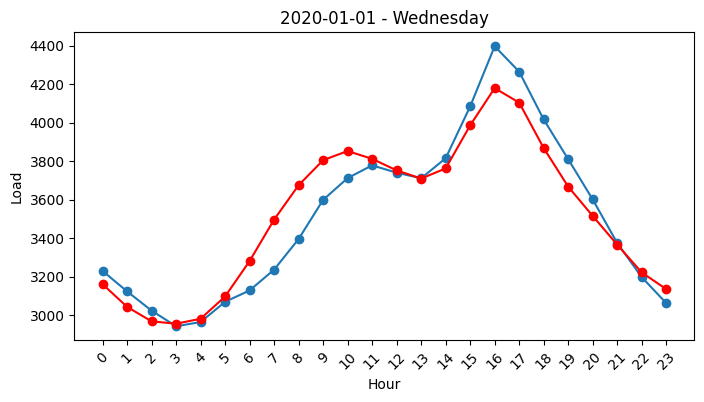

In [199]:
ar_model = AutoReg(train_data['load'], lags=168).fit()

pred = ar_model.predict(start = train_end_index +1, end = train_end_index + n+1, dynamic=False)

plt.figure(figsize=(8,4))
plt.plot(test_data['date'].dt.hour,test_data['load'], marker = 'o')
plt.plot(test_data['date'].dt.hour,pred[0:24], color='red', marker = 'o')
plt.xticks(test_data['date'].dt.hour, rotation = 45)
plt.title(test_data.iloc[0 ,0].strftime("%Y-%m-%d") + " - " + test_data['date'].dt.strftime("%A").iloc[0])
plt.xlabel("Hour")
plt.ylabel("Load")
plt.show()

In [113]:
train_data = df['load'][:len(df)-696]
test_data = df['load'][len(df)-696:]

ar_model = AutoReg(train_data, lags=168).fit()
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:                   load   No. Observations:                21936
Model:                   AutoReg(168)   Log Likelihood             -129539.228
Method:               Conditional MLE   S.D. of innovations             92.941
Date:                Thu, 01 Jun 2023   AIC                         259418.456
Time:                        11:23:34   BIC                         260776.450
Sample:                           168   HQIC                        259860.934
                                21936                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.3249      7.665      1.347      0.178      -4.698      25.348
load.L1        0.9365      0.007    138.365      0.000       0.923       0.950
load.L2       -0.0517      0.009     -5.606      0.0

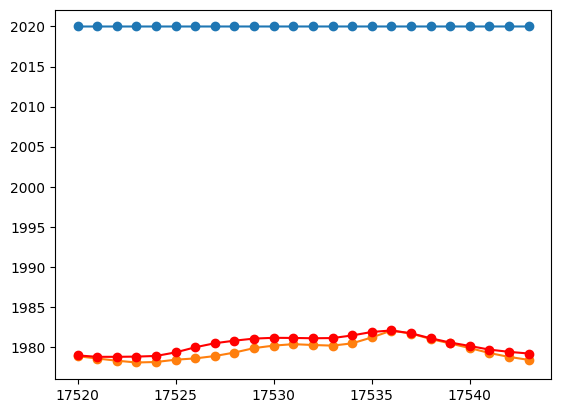